<a href="https://colab.research.google.com/github/waelrash1/forecastingmodelsPY/blob/main/CH10/CH10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  Forecasting multiple time series

* Examining the VAR model
* Exploring Granger causality to validate the use of the VAR model
* Forecasting multiple time series using the VAR model


* SARIMAX model can be used to include the impact of exogenous variables on a time series. 
* With the SARIMAX model, the relationship is unidirectional: we assume that the exogenous variable has an impact on the target only.
* However, it is possible that two time series have a bidirectional relationship,
> meaning that time series t1 is a predictor of time series t2, and time series t2 is also a predictor for time series t1.
* This brings us to the vector autoregression (VAR) model. 

## Examining the VAR model
* The vector autoregression (VAR) model captures the relationship between multiple series as they change over time. 
* In this model, each series has an impact on the other, unlike the SARIMAX model where the exogenous variable had an impact on the target, but not the other way around. 
* VAR model can be seen as a generalization of the $AR(p)$ model to allow for the forecast of multiple time series.
* Therefore, we can also denote the VAR model as $VAR(p)$, where $p$ is the order and hasthe same meaning as in the $AR(p)$ model.


## Examining the VAR model cont.
* Recall that $AR(p)$:

$$
\Large y_t= C+ \phi_1 y_{t-1}+\phi_2 y_{t-2}+...+\phi_p y_{t-p}+\epsilon_t
$$


## Examining the VAR model cont.
* For simplicity, let’s consider a system with two time series, denoted as y1,t and y2,t, and an order of 1, meaning that p = 1. Then, using matrix notation, the VAR(1) model can be expressed as 

$$
\Large \begin{bmatrix}
y_{1,t}\\
y_{2,t}
\end{bmatrix} =\begin{bmatrix}
C_{1}\\
C_{2}
\end{bmatrix}+ \begin{bmatrix}
\phi_{1,1}, \phi_{1,2}\\
\phi_{2,1}, \phi_{2,2}
\end{bmatrix}\begin{bmatrix}
y_{1,t-1}\\
y_{2,t-1}
\end{bmatrix} + \begin{bmatrix}
\epsilon_{1,t}\\
\epsilon_{2,t}
\end{bmatrix}
$$

## Vector autoregression model
* The vector autoregression model VAR(p) models the relationship of two or more time series. In this model, each time series has an impact on the others. 
* This means that past values of one time series affect the other time series, and vice versa.
* The VAR(p) model can be seen as a generalization of the AR(p) model that allows for multiple time series. Just like in the AR(p) model, the order p of the VAR(p) model determines how many lagged values impact the present value of a series. 
* In this model, however, we also include lagged values of other time series.

* For two time series, the general equation for the VAR(p) model is a linear combination of a vector of constants, past values of both time series, and a vector of error terms:
* Note that the time series must be stationary to apply the VAR model.


$$
\Large \begin{bmatrix}
y_{1,t}\\
y_{2,t}
\end{bmatrix} =\begin{bmatrix}
C_{1}\\
C_{2}
\end{bmatrix}+ \begin{bmatrix}
\phi_{1,1}^1, \phi_{1,2}^1\\
\phi_{2,1}^1, \phi_{2,2}^1
\end{bmatrix}\begin{bmatrix}
y_{1,t-1}\\
y_{2,t-1}
\end{bmatrix} + \begin{bmatrix}
\phi_{1,1}^2, \phi_{1,2}^2\\
\phi_{2,1}^2, \phi_{2,2}^2
\end{bmatrix}\begin{bmatrix}
y_{1,t-2}\\
y_{2,t-2}
\end{bmatrix} +...+ \begin{bmatrix}
\phi_{1,1}^p, \phi_{1,2}^p\\
\phi_{2,1}^p, \phi_{2,2}^p
\end{bmatrix}\begin{bmatrix}
y_{1,t-p}\\
y_{2,t-p}
\end{bmatrix} +\begin{bmatrix}
\epsilon_{1,t}\\
\epsilon_{2,t}
\end{bmatrix}
$$

## Real consumption and real disposable income
* This time we’ll explore the relationship between real disposable income and real consumption.
> Real consumption expresses how much money people spend, while real disposable
income represents how much money is available to spend. Therefore, it is a reason-
able hypothesis that a higher amount of disposable income could signal higher con-
sumption. The opposite can also be true, with higher consumption meaning that more income is available for spending. This bidirectional relationship can be captured by a
VAR model.

## Var Procedure

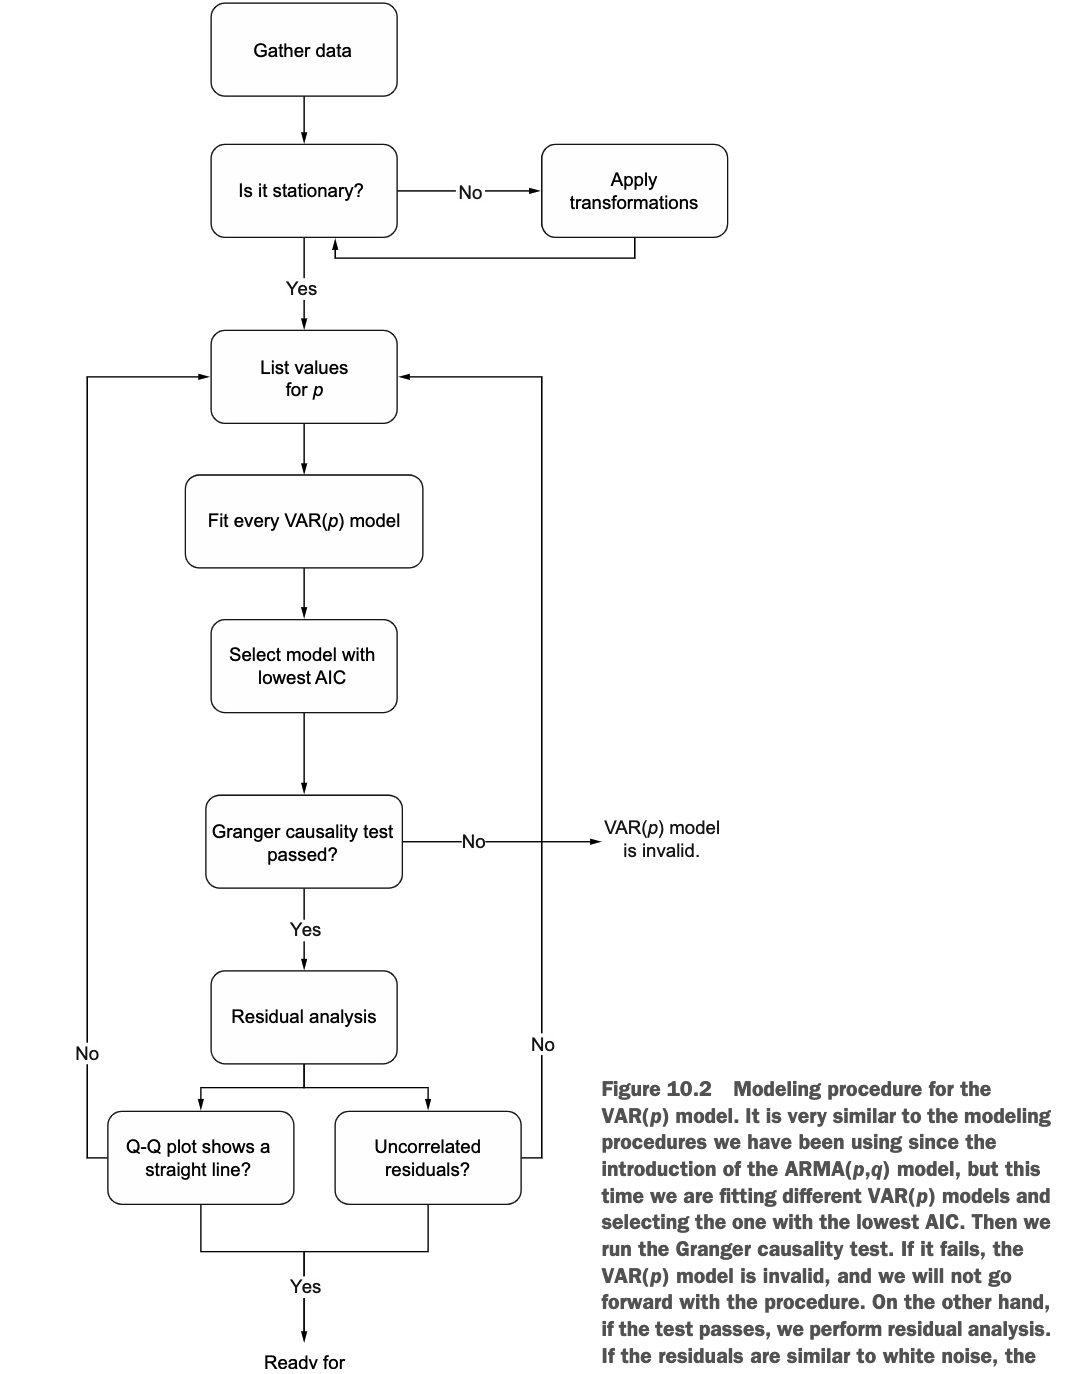

In [4]:
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.statespace.varmax import VARMAX
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [5]:
macro_econ_data = sm.datasets.macrodata.load_pandas().data
macro_econ_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


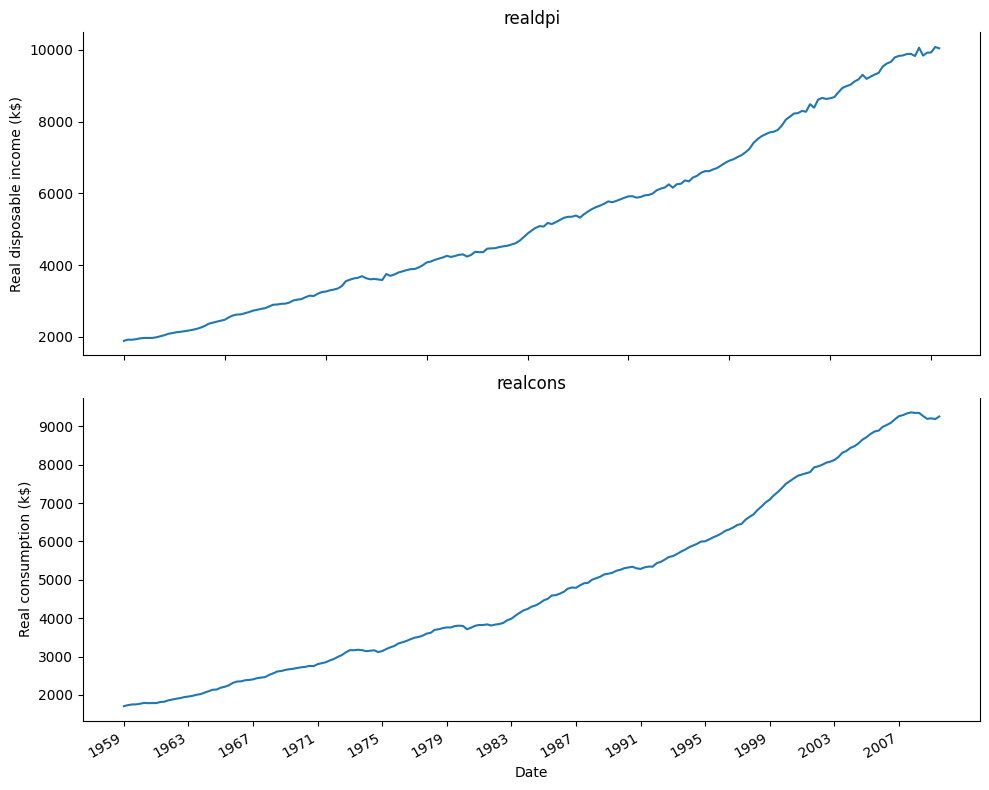

In [6]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income (k$)')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)

ax2.plot(macro_econ_data['realcons'])
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH10_F01_peixeiro.png', dpi=300)

# VAR 

## 1- Test Stationarity

In [7]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: 2.986025351954683
p-value: 1.0

---------------------

realcons
ADF Statistic: 1.549912338050964
p-value: 0.9976992503412904


> Not-stionary and need to apply difference.

# VAR 

## 2- Transformation 
* Apply time series difference
* Test the stationarity using ADFuler test


In [8]:
ad_fuller_result_1 = adfuller(macro_econ_data['realdpi'].diff()[1:])

print('realdpi')
print(f'ADF Statistic: {ad_fuller_result_1[0]}')
print(f'p-value: {ad_fuller_result_1[1]}')

print('\n---------------------\n')

ad_fuller_result_2 = adfuller(macro_econ_data['realcons'].diff()[1:])

print('realcons')
print(f'ADF Statistic: {ad_fuller_result_2[0]}')
print(f'p-value: {ad_fuller_result_2[1]}')

realdpi
ADF Statistic: -8.864893340673007
p-value: 1.4493606159108096e-14

---------------------

realcons
ADF Statistic: -4.204306080845247
p-value: 0.0006479282158627571


# VAR 

## 3- Train VARMAX model

In [9]:
from typing import Union
from tqdm import tqdm_notebook
from statsmodels.tsa.statespace.varmax import VARMAX

def optimize_VAR(train) -> pd.DataFrame:
    
    results = []
    
    for i in tqdm_notebook(range(9)):
        try:
            model = VARMAX(train, order=(i, 0), verbose=False).fit(dips=False)
        except:
            continue
            
        aic = model.aic
        results.append([i, aic])
        
    result_df = pd.DataFrame(results)
    result_df.columns = ['p', 'AIC']
    
    result_df = result_df.sort_values(by='AIC', ascending=True).reset_index(drop=True)
    
    return result_df

In [10]:
endog = macro_econ_data[['realdpi', 'realcons']]

endog_diff = macro_econ_data[['realdpi', 'realcons']].diff()[1:]

train = endog_diff[:162]
test = endog_diff[162:]

result_df = optimize_VAR(train)
result_df

  0%|          | 0/9 [00:00<?, ?it/s]

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.61849D+00    |proj g|=  2.88206D-03


 This problem is unconstrained.



At iterate    5    f=  9.61847D+00    |proj g|=  2.89231D-03

At iterate   10    f=  9.61834D+00    |proj g|=  3.17859D-03

At iterate   15    f=  9.61833D+00    |proj g|=  2.08508D-03

At iterate   20    f=  9.61831D+00    |proj g|=  7.03839D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    9     21     25      1     0     0   7.094D-05   9.618D+00
  F =   9.6183127883309769     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           13     M =           10

At X0         0 variables are exactly at the bounds

At iter

 This problem is unconstrained.



At iterate    5    f=  9.58112D+00    |proj g|=  2.53873D-03

At iterate   10    f=  9.58065D+00    |proj g|=  4.18736D-03

At iterate   15    f=  9.58061D+00    |proj g|=  7.55641D-04

At iterate   20    f=  9.58056D+00    |proj g|=  3.53008D-03

At iterate   25    f=  9.58054D+00    |proj g|=  3.50388D-04

At iterate   30    f=  9.58053D+00    |proj g|=  1.10726D-03

At iterate   35    f=  9.58053D+00    |proj g|=  9.72921D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   13     36     42      1     0     0   6.793D-05   9.581D+00
  F =   9.5805298391677205     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH   

 This problem is unconstrained.



At iterate    5    f=  9.53548D+00    |proj g|=  2.12456D-03

At iterate   10    f=  9.53459D+00    |proj g|=  1.00744D-02

At iterate   15    f=  9.53435D+00    |proj g|=  6.18729D-04

At iterate   20    f=  9.53427D+00    |proj g|=  6.00981D-03

At iterate   25    f=  9.53419D+00    |proj g|=  2.10886D-04

At iterate   30    f=  9.53418D+00    |proj g|=  6.25480D-04

At iterate   35    f=  9.53417D+00    |proj g|=  2.64335D-04

At iterate   40    f=  9.53417D+00    |proj g|=  1.01020D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   17     41     46      1     0     0   8.900D-05   9.534D+00
  F =   9.53416690591

 This problem is unconstrained.



At iterate    5    f=  9.53073D+00    |proj g|=  3.37638D-03

At iterate   10    f=  9.52882D+00    |proj g|=  5.77358D-03

At iterate   15    f=  9.52872D+00    |proj g|=  1.19733D-03

At iterate   20    f=  9.52848D+00    |proj g|=  6.53570D-03

At iterate   25    f=  9.52841D+00    |proj g|=  3.15860D-04

At iterate   30    f=  9.52840D+00    |proj g|=  2.43446D-04

At iterate   35    f=  9.52839D+00    |proj g|=  1.11644D-03

At iterate   40    f=  9.52838D+00    |proj g|=  4.90701D-04

At iterate   45    f=  9.52838D+00    |proj g|=  8.83334D-05

At iterate   50    f=  9.52838D+00    |proj g|=  2.30270D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           25     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.49099D+00    |proj g|=  2.18784D-02

At iterate    5    f=  9.49065D+00    |proj g|=  3.71658D-03

At iterate   10    f=  9.48825D+00    |proj g|=  2.28031D-02

At iterate   15    f=  9.48729D+00    |proj g|=  1.02704D-03

At iterate   20    f=  9.48716D+00    |proj g|=  6.60103D-03

At iterate   25    f=  9.48680D+00    |proj g|=  6.00235D-04

At iterate   30    f=  9.48679D+00    |proj g|=  7.33782D-04

At iterate   35    f=  9.48679D+00    |proj g|=  8.50687D-04

At iterate   40    f=  9.48676D+00    |proj g|=  1.74285D-03

At iterate   45    f=  9.48675D+00    |proj g|=  1.30320D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           29     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.47781D+00    |proj g|=  3.35701D-02

At iterate    5    f=  9.47727D+00    |proj g|=  4.35159D-03

At iterate   10    f=  9.47491D+00    |proj g|=  2.97492D-02

At iterate   15    f=  9.47252D+00    |proj g|=  1.25347D-03

At iterate   20    f=  9.47249D+00    |proj g|=  2.06327D-03

At iterate   25    f=  9.47196D+00    |proj g|=  8.01763D-03

At iterate   30    f=  9.47183D+00    |proj g|=  4.76210D-04

At iterate   35    f=  9.47182D+00    |proj g|=  1.12303D-03

At iterate   40    f=  9.47181D+00    |proj g|=  1.76937D-03

At iterate   45    f=  9.47179D+00    |proj g|=  1.35956D-03

At iterate   50    f=  9.47178D+00    |proj g|=  8.87722D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

 This problem is unconstrained.



At iterate    5    f=  9.47478D+00    |proj g|=  5.08595D-03

At iterate   10    f=  9.47087D+00    |proj g|=  2.26393D-02

At iterate   15    f=  9.46827D+00    |proj g|=  1.86586D-03

At iterate   20    f=  9.46823D+00    |proj g|=  1.91934D-03

At iterate   25    f=  9.46766D+00    |proj g|=  1.74473D-02

At iterate   30    f=  9.46737D+00    |proj g|=  1.13669D-03

At iterate   35    f=  9.46733D+00    |proj g|=  2.53999D-03

At iterate   40    f=  9.46732D+00    |proj g|=  4.80082D-04

At iterate   45    f=  9.46729D+00    |proj g|=  1.73007D-03

At iterate   50    f=  9.46728D+00    |proj g|=  4.90118D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tn

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           37     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.46504D+00    |proj g|=  4.42335D-02

At iterate    5    f=  9.46428D+00    |proj g|=  5.80453D-03

At iterate   10    f=  9.46011D+00    |proj g|=  5.15624D-02

At iterate   15    f=  9.45574D+00    |proj g|=  5.77425D-03

At iterate   20    f=  9.45555D+00    |proj g|=  1.68747D-03

At iterate   25    f=  9.45505D+00    |proj g|=  2.55599D-02

At iterate   30    f=  9.45428D+00    |proj g|=  6.93919D-04

At iterate   35    f=  9.45427D+00    |proj g|=  1.79650D-03

At iterate   40    f=  9.45417D+00    |proj g|=  2.82096D-03

At iterate   45    f=  9.45416D+00    |proj g|=  2.99444D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = nu

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855598
3,4,3129.194047
4,2,3130.091668
5,7,3133.398275
6,1,3134.333343
7,8,3137.149013


In [11]:
result_df

,p,AIC
0,3,3123.070078
1,5,3123.708523
2,6,3126.855598
3,4,3129.194047
4,2,3130.091668
5,7,3133.398275
6,1,3134.333343
7,8,3137.149013


In [12]:
print('realcons Granger-causes realdpi?\n')
print('------------------')
granger_1 = grangercausalitytests(macro_econ_data[['realdpi', 'realcons']].diff()[1:], [3])

print('\nrealdpi Granger-causes realcons?\n')
print('------------------')
granger_2 = grangercausalitytests(macro_econ_data[['realcons', 'realdpi']].diff()[1:], [3])

realcons Granger-causes realdpi?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=28.7191 , p=0.0000  , df=3
likelihood ratio test: chi2=26.8268 , p=0.0000  , df=3
parameter F test:         F=9.2363  , p=0.0000  , df_denom=192, df_num=3

realdpi Granger-causes realcons?

------------------

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3
ssr based chi2 test:   chi2=8.7625  , p=0.0326  , df=3
likelihood ratio test: chi2=8.5751  , p=0.0355  , df=3
parameter F test:         F=2.8181  , p=0.0403  , df_denom=192, df_num=3


In [ ]:
best_model = VARMAX(train, order=(3,0))
best_model_fit = best_model.fit(disp=False)

print(best_model_fit.summary())

                              Statespace Model Results                             
Dep. Variable:     ['realdpi', 'realcons']   No. Observations:                  162
Model:                              VAR(3)   Log Likelihood               -1544.535
                               + intercept   AIC                           3123.070
Date:                     Tue, 07 Sep 2021   BIC                           3175.559
Time:                             15:24:22   HQIC                          3144.381
Sample:                                  0                                         
                                     - 162                                         
Covariance Type:                       opg                                         
Ljung-Box (L1) (Q):             0.01, 0.03   Jarque-Bera (JB):          43.85, 4.35
Prob(Q):                        0.91, 0.87   Prob(JB):                   0.00, 0.11
Heteroskedasticity (H):         4.44, 3.59   Skew:                      0.14

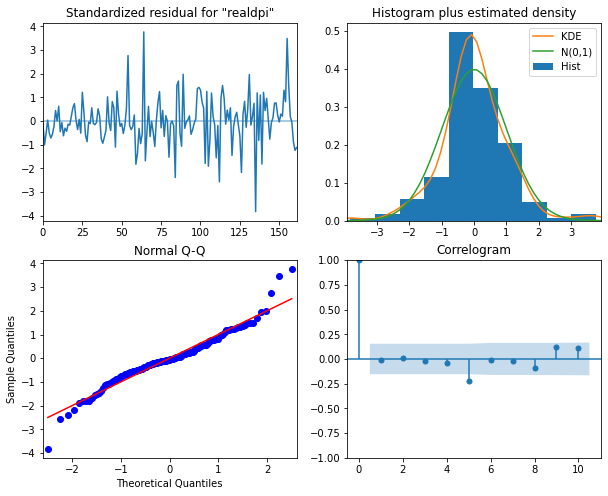

In [ ]:
# realdpi
best_model_fit.plot_diagnostics(figsize=(10,8), variable=0);

plt.savefig('figures/CH10_F04_peixeiro.png', dpi=300)

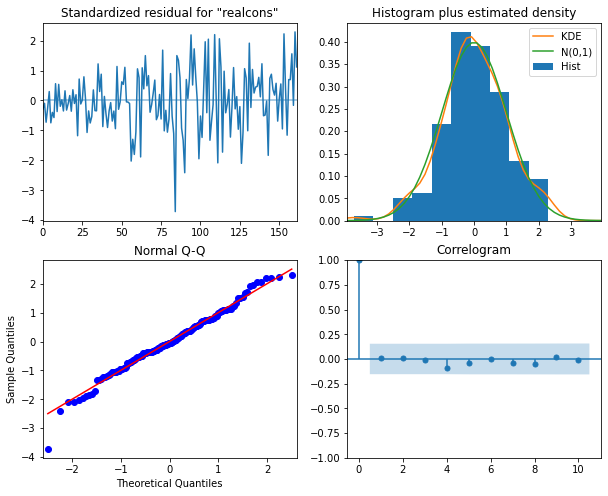

In [ ]:
# realcons
best_model_fit.plot_diagnostics(figsize=(10,8), variable=1);

plt.savefig('figures/CH10_F05_peixeiro.png', dpi=300)

In [ ]:
realgdp_residuals = best_model_fit.resid['realdpi']

lbvalue, pvalue = acorr_ljungbox(realgdp_residuals, np.arange(1, 11, 1))

print(pvalue)

[0.91405261 0.98537862 0.9945855  0.98423356 0.10348741 0.16445201
 0.23379802 0.21253698 0.14870227 0.12191099]


In [ ]:
realcons_residuals = best_model_fit.resid['realcons']

lbvalue, pvalue = acorr_ljungbox(realcons_residuals, np.arange(1, 11, 1))

print(pvalue)

[0.87794847 0.96629006 0.99531248 0.99358636 0.99592666 0.99241196
 0.9945818  0.97605013 0.98252595 0.99168257]


In [ ]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'VAR':

        realdpi_pred_VAR = []
        realcons_pred_VAR = []
        
        for i in range(train_len, total_len, window):
            model = VARMAX(df[:i], order=(3,0))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            
            oos_pred_realdpi = predictions.predicted_mean.iloc[-window:]['realdpi']
            oos_pred_realcons = predictions.predicted_mean.iloc[-window:]['realcons']
            
            realdpi_pred_VAR.extend(oos_pred_realdpi)
            realcons_pred_VAR.extend(oos_pred_realcons)
        
        return realdpi_pred_VAR, realcons_pred_VAR
    
    elif method == 'last':
        realdpi_pred_last = []
        realcons_pred_last = []
        
        for i in range(train_len, total_len, window):
            
            realdpi_last = df[:i].iloc[-1]['realdpi']
            realcons_last = df[:i].iloc[-1]['realcons']
            
            realdpi_pred_last.extend(realdpi_last for _ in range(window))
            realcons_pred_last.extend(realcons_last for _ in range(window))
            
        return realdpi_pred_last, realcons_pred_last

In [ ]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 4

realdpi_pred_VAR, realcons_pred_VAR = recursive_forecast(endog_diff, TRAIN_LEN, HORIZON, WINDOW, 'VAR')

In [ ]:
test = endog[163:]

test['realdpi_pred_VAR'] = pd.Series()
test['realdpi_pred_VAR'] = endog.iloc[162]['realdpi'] + np.cumsum(realdpi_pred_VAR)

test['realcons_pred_VAR'] = pd.Series()
test['realcons_pred_VAR'] = endog.iloc[162]['realcons'] + np.cumsum(realcons_pred_VAR)

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR
163,7887.7,7389.2,7829.225426,7354.324923
164,8053.4,7501.3,7897.191791,7430.257788
165,8135.9,7571.8,7960.567992,7496.633202
166,8222.3,7645.9,8014.759416,7556.617892
167,8234.6,7713.5,8080.705065,7631.000039
168,8296.5,7744.3,8142.394234,7692.847380
169,8273.7,7773.5,8200.124659,7753.866075
170,8484.5,7807.7,8259.362406,7812.532650
171,8385.5,7930.0,8264.386386,7864.633238
172,8611.6,7957.3,8320.858709,7895.057974


In [ ]:
realdpi_pred_last, realcons_pred_last = recursive_forecast(endog, TRAIN_LEN, HORIZON, WINDOW, 'last')

test['realdpi_pred_last'] = realdpi_pred_last
test['realcons_pred_last'] = realcons_pred_last

test

,realdpi,realcons,realdpi_pred_VAR,realcons_pred_VAR,realdpi_pred_last,realcons_pred_last
163,7887.7,7389.2,7829.225426,7354.324923,7716.0,7199.9
164,8053.4,7501.3,7897.191791,7430.257788,7716.0,7199.9
165,8135.9,7571.8,7960.567992,7496.633202,7716.0,7199.9
166,8222.3,7645.9,8014.759416,7556.617892,7716.0,7199.9
167,8234.6,7713.5,8080.705065,7631.000039,8135.9,7571.8
168,8296.5,7744.3,8142.394234,7692.847380,8135.9,7571.8
169,8273.7,7773.5,8200.124659,7753.866075,8135.9,7571.8
170,8484.5,7807.7,8259.362406,7812.532650,8135.9,7571.8
171,8385.5,7930.0,8264.386386,7864.633238,8273.7,7773.5
172,8611.6,7957.3,8320.858709,7895.057974,8273.7,7773.5


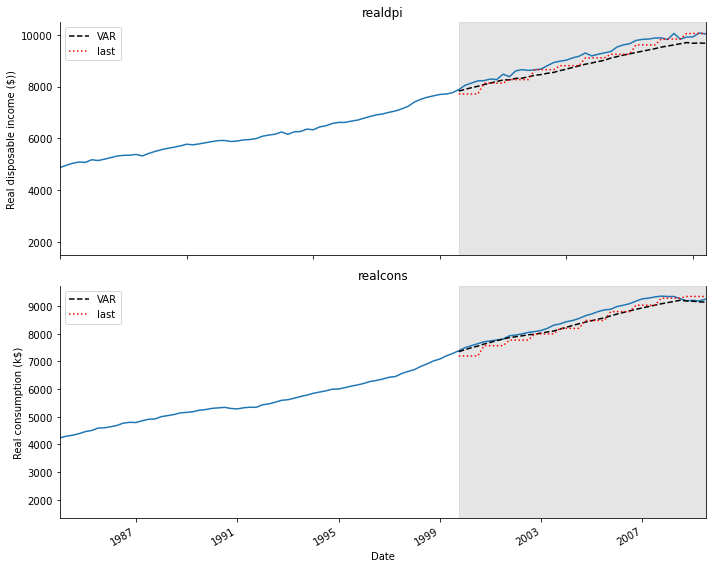

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, figsize=(10,8))

ax1.plot(macro_econ_data['realdpi'])
ax1.plot(test['realdpi_pred_VAR'], 'k--', label='VAR')
ax1.plot(test['realdpi_pred_last'], 'r:', label='last')
ax1.set_xlabel('Date')
ax1.set_ylabel('Real disposable income ($))')
ax1.set_title('realdpi')
ax1.spines['top'].set_alpha(0)
ax1.axvspan(163, 202, color='#808080', alpha=0.2)
ax1.set_xlim(100, 202)
ax1.legend(loc=2)

ax2.plot(macro_econ_data['realcons'])
ax2.plot(test['realcons_pred_VAR'], 'k--', label='VAR')
ax2.plot(test['realcons_pred_last'], 'r:', label='last')
ax2.set_xlabel('Date')
ax2.set_ylabel('Real consumption (k$)')
ax2.set_title('realcons')
ax2.spines['top'].set_alpha(0)
ax2.axvspan(163, 202, color='#808080', alpha=0.2)
ax2.set_xlim(100, 202)
ax2.legend(loc=2)

plt.xticks(np.arange(0, 208, 16), np.arange(1959, 2010, 4))
plt.xlim(100, 202)

fig.autofmt_xdate()
plt.tight_layout()

plt.savefig('figures/CH10_F06_peixeiro.png', dpi=300)

In [ ]:
def mape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:
mape_realdpi_VAR = mape(test['realdpi'], test['realdpi_pred_VAR'])
mape_realdpi_last = mape(test['realdpi'], test['realdpi_pred_last'])

mape_realcons_VAR = mape(test['realcons'], test['realcons_pred_VAR'])
mape_realcons_last = mape(test['realcons'], test['realcons_pred_last'])

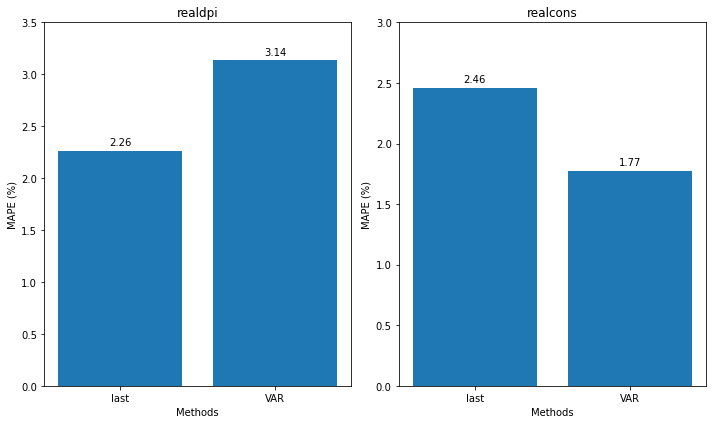

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10,6))

x = ['last', 'VAR']
y1 = [mape_realdpi_last, mape_realdpi_VAR]
y2 = [mape_realcons_last, mape_realcons_VAR]

ax1.bar(x, y1)
ax1.set_xlabel('Methods')
ax1.set_ylabel('MAPE (%)')
ax1.set_title('realdpi')
ax1.set_ylim(0, 3.5)

ax2.bar(x,y2)
ax2.set_xlabel('Methods')
ax2.set_ylabel('MAPE (%)')
ax2.set_title('realcons')
ax2.set_ylim(0, 3)

for index, value in enumerate(y1):
    ax1.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')
    
for index, value in enumerate(y2):
    ax2.text(x=index, y=value + 0.05, s=str(round(value,2)), ha='center')

plt.tight_layout()

plt.savefig('figures/CH10_F07_peixeiro.png', dpi=300)